This notebook provides a minimal working example of the image-to-painting translation (progressive rendering) in the preprint paper "Stylized Neural Painting, arXiv:2011.08114."

[Project Page](https://jiupinjia.github.io/neuralpainter/) | [GitHub](https://github.com/jiupinjia/stylized-neural-painting) | [Preprint](https://arxiv.org/abs/2011.08114)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">   The project </a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In [ ]:
# Clone the repository
!git clone https://github.com/jiupinjia/stylized-neural-painting

Cloning into 'stylized-neural-painting'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 198 (delta 52), reused 39 (delta 39), pack-reused 140
Receiving objects: 100% (198/198), 3.63 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
cd stylized-neural-painting

/content/stylized-neural-painting


In [ ]:
import argparse

import torch
torch.cuda.current_device()
import torch.optim as optim

from painter import *
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# download and unzip...
file_id = '1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG'
file_name = './checkpoints_G_oilpaintbrush.zip'

!gdown --id {file_id}
!unzip {file_name}

file_id = 'https://drive.google.com/file/d/19Yrj15v9kHvWzkK9o_GSZtvQaJPmcRYQ/view?usp=sharing'#
file_name = './checkpoints_G_watercolor.zip'

!gdown --fuzzy {file_id}
!unzip {file_name}

file_id = 'https://drive.google.com/file/d/1XsjncjlSdQh2dbZ3X1qf1M8pDc8GLbNy/view?usp=sharing'
file_name = './checkpoints_G_markerpen.zip'

!gdown --fuzzy {file_id}
!unzip {file_name}

file_id = 'https://drive.google.com/file/d/162ykmRX8TBGVRnJIof8NeqN7cuwwuzIF/view?usp=sharing'
file_name = './checkpoints_G_rectangle.zip'

!gdown --fuzzy {file_id}
!unzip {file_name}

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG
From (redirected): https://drive.google.com/uc?id=1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG&confirm=t&uuid=b5839d3a-4a66-482a-b358-6c0cb4127939
To: /content/stylized-neural-painting/checkpoints_G_oilpaintbrush.zip
100% 181M/181M [00:03<00:00, 52.2MB/s]
Archive:  ./checkpoints_G_oilpaintbrush.zip
   creating: checkpoints_G_oilpaintbrush/
  inflating: checkpoints_G_oilpaintbrush/last_ckpt.pt  
Downloading...
From (original): https://drive.google.com/uc?id=19Yrj15v9kHvWzkK9o_GSZtvQaJPmcRYQ
From (redirected): https://drive.google.com/uc?id=19Yrj15v9kHvWzkK9o_GSZtvQaJPmcRYQ&confirm=t&uuid=7444eca4-2bf3-4117-bea6-78bdb5cc7538
To: /content/stylized-neural-painting/checkpoints_G_watercolor

Saving opm_panel.jpg to opm_panel.jpg
opm_panel.jpg uploaded and saved successfully.


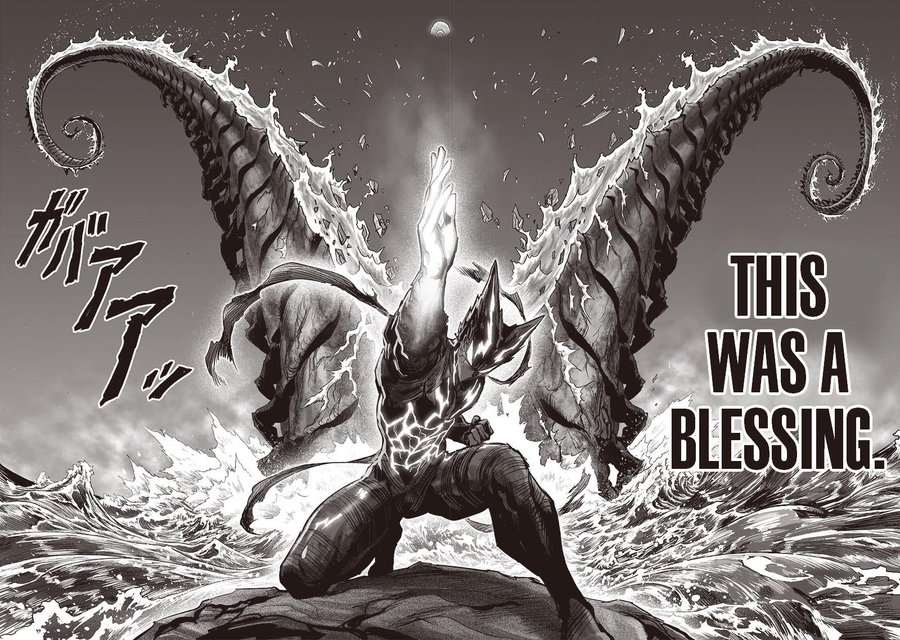

In [ ]:
from google.colab import files
from IPython.display import Image
import os

# Step 1: Upload the image
uploaded = files.upload()

# Step 2: Save the image to a specific directory
upload_dir = '/content/stylized-neural-painting/test_images/'
os.makedirs(upload_dir, exist_ok=True)

for filename, content in uploaded.items():
    # Combine upload directory with filename to get full path
    file_path = os.path.join(upload_dir, filename)

    # Write the file to the specified directory
    with open(file_path, 'wb') as f:
        f.write(content)

    print(f'{filename} uploaded and saved successfully.')

Image(filename)

In [ ]:
#@title SETTINGS
parser = argparse.ArgumentParser(description='STYLIZED NEURAL PAINTING')
args = parser.parse_args(args=[])
args.img_path = file_path # path to input photo
args.renderer = 'oilpaintbrush' #@param ["watercolor", "markerpen", "oilpaintbrush", "rectangle"]
args.canvas_color = 'white' #@param ["black", "white"]
args.canvas_size = 512 # size of the canvas for stroke rendering'

#whether to keep input aspect ratio when saving outputs
args.keep_aspect_ratio = True #@param {type:"boolean"}

 # max number of strokes
args.max_m_strokes = 500 #@param {type:"slider", min:50, max:500, step:5}

args.max_divide = 5 # divide an image up-to max_divide x max_divide patches
args.beta_L1 = 1.0 # weight for L1 loss
args.with_ot_loss = False # set True for imporving the convergence by using optimal transportation loss, but will slow-down the speed
args.beta_ot = 0.1 # weight for optimal transportation loss
args.net_G = 'zou-fusion-net' # renderer architecture

if(args.renderer == 'oilpaintbrush'):
  args.renderer_checkpoint_dir = './checkpoints_G_oilpaintbrush' # dir to load the pretrained neu-renderer
elif(args.renderer == 'markerpen'):
  args.renderer_checkpoint_dir = './checkpoints_G_markerpen'
elif(args.renderer == 'watercolor'):
  args.renderer_checkpoint_dir = './checkpoints_G_watercolor'
elif(args.renderer == 'rectangle'):
  args.renderer_checkpoint_dir = './checkpoints_G_rectangle'

# learning rate for stroke searching
args.lr = 0.01 #@param {type:"slider", min:0.001, max:0.025, step:0.001}
args.output_dir = './output' # dir to save painting results
args.disable_preview = True # disable cv2.imshow, for running remotely without x-display

Defining the optimization loop for the painter

In [ ]:
def optimize_x(pt):

    pt._load_checkpoint()
    pt.net_G.eval()

    print('begin drawing...')

    PARAMS = np.zeros([1, 0, pt.rderr.d], np.float32)

    if pt.rderr.canvas_color == 'white':
        CANVAS_tmp = torch.ones([1, 3, 128, 128]).to(device)
    else:
        CANVAS_tmp = torch.zeros([1, 3, 128, 128]).to(device)

    for pt.m_grid in range(1, pt.max_divide + 1):

        pt.img_batch = utils.img2patches(pt.img_, pt.m_grid, pt.net_G.out_size).to(device)
        pt.G_final_pred_canvas = CANVAS_tmp

        pt.initialize_params()
        pt.x_ctt.requires_grad = True
        pt.x_color.requires_grad = True
        pt.x_alpha.requires_grad = True
        utils.set_requires_grad(pt.net_G, False)

        pt.optimizer_x = optim.RMSprop([pt.x_ctt, pt.x_color, pt.x_alpha], lr=pt.lr, centered=True)

        pt.step_id = 0
        for pt.anchor_id in range(0, pt.m_strokes_per_block):
            pt.stroke_sampler(pt.anchor_id)
            iters_per_stroke = int(500 / pt.m_strokes_per_block)
            for i in range(iters_per_stroke):
                pt.G_pred_canvas = CANVAS_tmp

                # update x
                pt.optimizer_x.zero_grad()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt._forward_pass()
                pt._drawing_step_states()
                pt._backward_x()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt.optimizer_x.step()
                pt.step_id += 1

        v = pt._normalize_strokes(pt.x)
        v = pt._shuffle_strokes_and_reshape(v)
        PARAMS = np.concatenate([PARAMS, v], axis=1)
        CANVAS_tmp = pt._render(PARAMS, save_jpgs=False, save_video=False)
        Image(CANVAS_tmp)
        CANVAS_tmp = utils.img2patches(CANVAS_tmp, pt.m_grid + 1, pt.net_G.out_size).to(device)

    pt._save_stroke_params(PARAMS)
    final_rendered_image = pt._render(PARAMS, save_jpgs=False, save_video=True)

    return final_rendered_image

In [ ]:
pt = ProgressivePainter(args=args)
final_rendered_image = optimize_x(pt)

initialize network with normal
loading renderer from pre-trained checkpoint...
begin drawing...
iteration step 0, G_loss: 0.00000, step_acc: 4.64364, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 1, G_loss: 0.52463, step_acc: 4.64492, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 2, G_loss: 0.52494, step_acc: 4.68739, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 3, G_loss: 0.52120, step_acc: 4.76465, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 4, G_loss: 0.51723, step_acc: 4.80394, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 5, G_loss: 0.51408, step_acc: 4.81409, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 6, G_loss: 0.51147, step_acc: 4.87107, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 7, G_loss: 0.50765, step_acc: 4.84965, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 8, G_loss: 0.50850, step_acc: 4.89832, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 9, G_loss: 0.50636, step_acc: 4.88461, grid_scale: 1 / 5, strokes: 1 / 9
iteration step 10, G_los

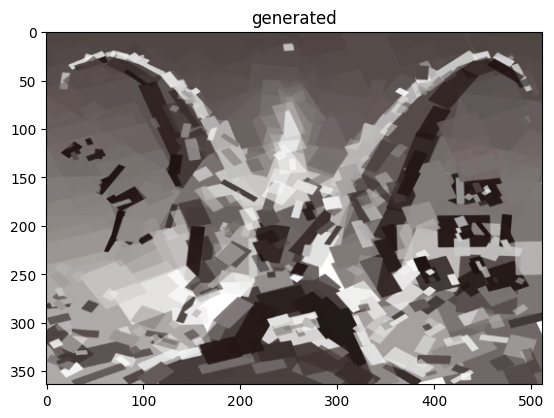

In [ ]:
plt.imshow(final_rendered_image), plt.title('generated')
plt.show()